# "Selective ControlNet" mini project

I've spent around 3 days on this task, and you're welcome to check out my results!

In [ ]:
!pip install controlnet_aux
!pip install diffusers transformers accelerate

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from diffusers import DDIMScheduler, UniPCMultistepScheduler, DPMSolverMultistepScheduler
from diffusers.utils import load_image, make_image_grid
import numpy as np
import torch
import cv2
from PIL import Image, ImageOps
from controlnet_aux import LineartDetector
import transformers
import torchvision
from torchvision import transforms

/beegfs/home/egor.burkov/face-replacement-2025-04/.env/lib/python3.9/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


## Task

**Input**: image $I$ + foreground prompt $P_f$ + background prompt $P_b$

**Output**: $I$ stylized according to $P_f$ (preserving the spatial structure) and the background in this image generated according to $P_b$ (any spatial structure, but semantically consistent around the object).

We are suggested to use ControlNet for spatial conditioning.

## Models

**Base model**. I've picked SD 1.5 because
* it's very efficient compared to SDXL/FLUX.1 and I didn't want to spend time on VRAM optimization,
* it's so popular that there is even a joint ControlNet+inpainting implementation in the diffusers library,
* even though the stock SD 1.5 is rather bad, there are hundreds of good checkpoints for various purposes; I've chosen a general-purpose checkpoint called Protogen.

**ControlNet**. For now I'll stick to the suggested "lineart" ControlNet, though other types are perfectly suitable. For automatic creation of control images, there is an image-to-lineart tool provided by Huggingface's controlnet_aux library.

**Implementation**. lllyasviel's GitHub seems to be abandoned, but they have converted their ControlNets to be used with diffusers library. This is my favorite library, and, importantly for this task, we can use diffusers' StableDiffusionControlNetInpaintPipeline with those models. (details on this interface below)

In [2]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_lineart", torch_dtype=torch.float16
)
diffusion_pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "darkstorm2150/Protogen_x3.4_Official_Release",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=False,
    safety_checker=None,
)
diffusion_pipeline = diffusion_pipeline.to("cuda")

diffusion_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    diffusion_pipeline.scheduler.config, use_karras_sigmas=True
)
# diffusion_pipeline.enable_model_cpu_offload()

# 512 is the recommended size for stock SD1.5, seems to be good for Protogen too
sd15_image_transform = transforms.Compose([
    transforms.v2.Resize(size=None, max_size=512),
])

# Neural net, converts images to line-art
lineart_detector = LineartDetector.from_pretrained("lllyasviel/Annotators")
# lineart_detector = lineart_detector.to("cuda")

def get_control_image(image: Image):
    control_image = lineart_detector(image)
    # this is the inverse of LineartDetector's preprocessing
    # which resizes to the closest multiple of 64, see controlnet_aux/util.py
    return control_image.resize(image.size)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
def resize_to_screen(image: Image):
    if image.width > 1500:
        factor = 1500 / image.width
        new_width = round(image.width * factor)
        new_height = round(image.height * factor)
        image = image.resize((new_width, new_height))
    return image

def display_row(images):
    return resize_to_screen(
        make_image_grid(images, rows=1, cols=len(images))
    )

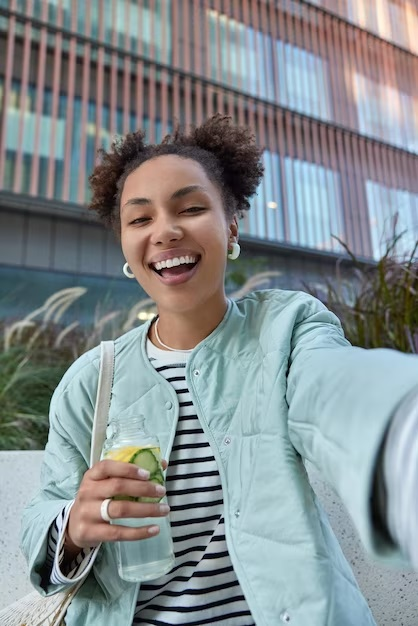

In [4]:
load_image("./dataset/a.jpg")

StableDiffusionControlNetInpaintPipeline was intended as an interface to use diffusion-based inpainting **and** ControlNet at the same time. However, by passing proper parameters, it is possible to use none, one, or both!

In our case, inpainting will be useful later for re-rendering the background. I will explain it later; for now let's just use it for plain ControlNet generation (control+text -> image). This can be achieved by providing full white inpainting mask (i.e. inpaint everything and disregard the initial image).

By the way, we can tune the degree to which the network follows the control by weighting the ControlNet outputs' addition, 0.0 (= control doesn't affect generation) to 1.0:

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

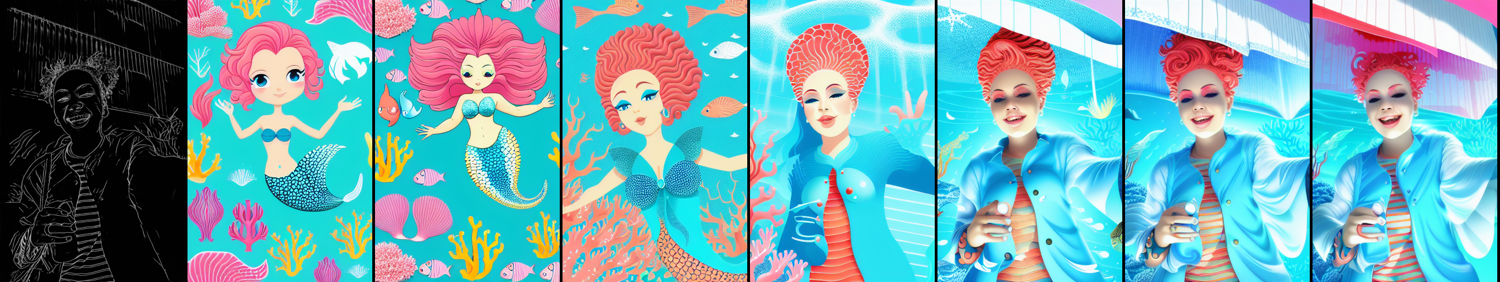

In [6]:
def text_to_image(prompt, control_image, **extra_diffusion_kwargs):
    """
    Generate an image based on a text prompt and a control image.
    """
    diffusion_kwargs = dict(
        prompt=prompt,
        negative_prompt="worst quality, low quality, blurry, ugly",
        image=init_image,
        mask_image=Image.new('L', init_image.size, color='white'), # full white = inpainting switched off
        control_image=control_image,
        controlnet_conditioning_scale=0.85,  # 0.0 = lineart control switched off
        num_inference_steps=30,
        generator=torch.Generator(device=diffusion_pipeline.device).manual_seed(123),
    )
    diffusion_kwargs.update(extra_diffusion_kwargs)
    return diffusion_pipeline(**diffusion_kwargs).images[0]

init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
control_image = get_control_image(init_image)
prompt = "mermaid underwater, blue clothes, corals and fishes background"

controlnet_scales = [0.0, 0.15, 0.3, 0.5, 0.7, 0.85, 1.0]
generated_images = [
    text_to_image(prompt, control_image, controlnet_conditioning_scale=c) for c in controlnet_scales
]
display_row([control_image] + generated_images)

## Specify the background in prompt (a stupid solution if we really have no time)

  0%|          | 0/30 [00:00<?, ?it/s]

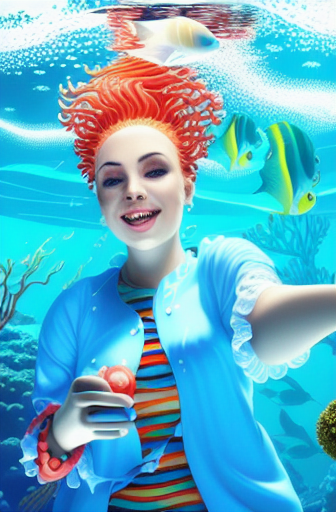

In [7]:
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
control_image = get_control_image(init_image)
prompt = "mermaid underwater, blue clothes, corals and fish in the background, vivid background with sea creatures, marine life"

text_to_image(prompt, control_image, controlnet_conditioning_scale=0.75)

Of course, the response isn't great. This could work with more advanced models that can follow complex prompts, but too much for SD 1.5.

We can use a good foreground segmentation algorithm like RMBG 1.4/2 to get a background mask and build something around it:

In [8]:
foreground_segm_model = transformers.pipeline(
    "image-segmentation",
    model="briaai/RMBG-1.4",
    trust_remote_code=True
)

Device set to use cuda:0


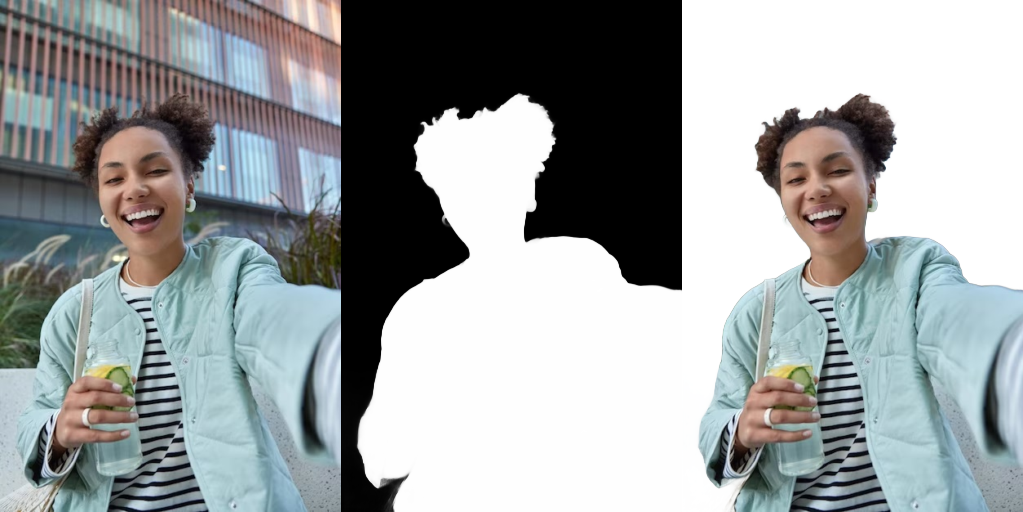

In [9]:
init_image = load_image("./dataset/a.jpg")
init_image = sd15_image_transform(init_image)
foreground_mask = foreground_segm_model(init_image, return_mask=True)

display_row([
    init_image,
    foreground_mask,
    Image.composite(init_image, Image.new('RGB', init_image.size, 'white'), foreground_mask)
])

## Erase background from the control image (a slightly less stupid solution if we have slightly more time)

  0%|          | 0/30 [00:00<?, ?it/s]

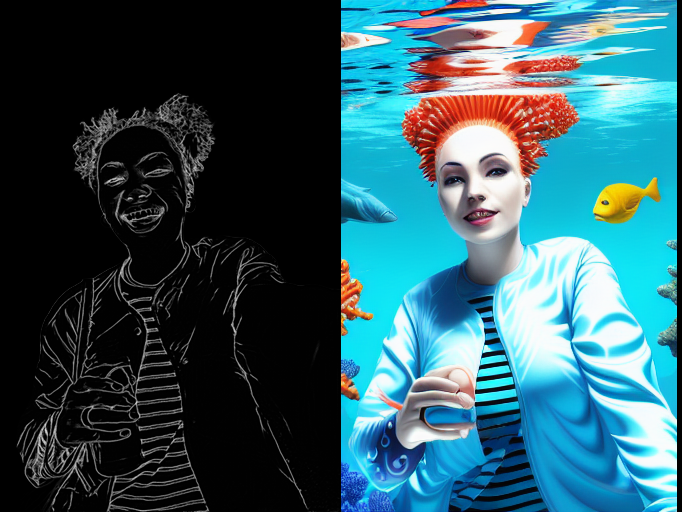

In [10]:
prompt = "mermaid underwater, blue clothes, corals and fish in the background, vivid background with sea creatures, marine life"
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
foreground_mask = foreground_segm_model(init_image, return_mask=True)
control_image = get_control_image(init_image)

# "Remove background" from the control image
control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

generated_image = text_to_image(prompt, control_image, controlnet_conditioning_scale=0.75)
display_row([control_image, generated_image])

  0%|          | 0/30 [00:00<?, ?it/s]

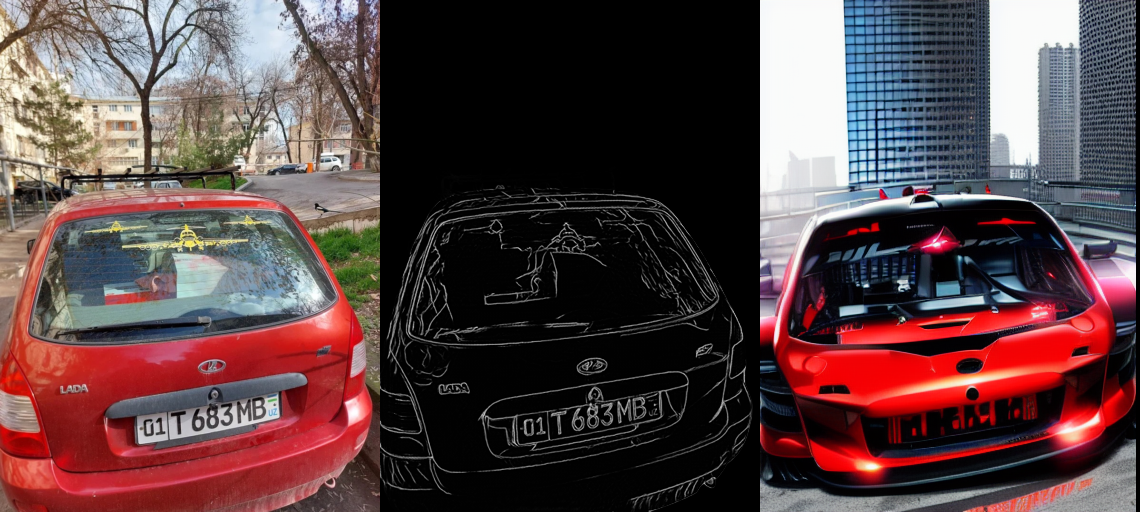

In [27]:
prompt = "a diabolic race car, many tall skyscrapers in the background, cyberpunk"
init_image = sd15_image_transform(load_image("./dataset/h.jpg"))
foreground_mask = foreground_segm_model(init_image, return_mask=True)
control_image = get_control_image(init_image)

# "Remove background" from the control image
control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

generated_image = text_to_image(prompt, control_image, controlnet_conditioning_scale=1.0)
display_row([init_image, control_image, generated_image])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/30 [00:00<?, ?it/s]

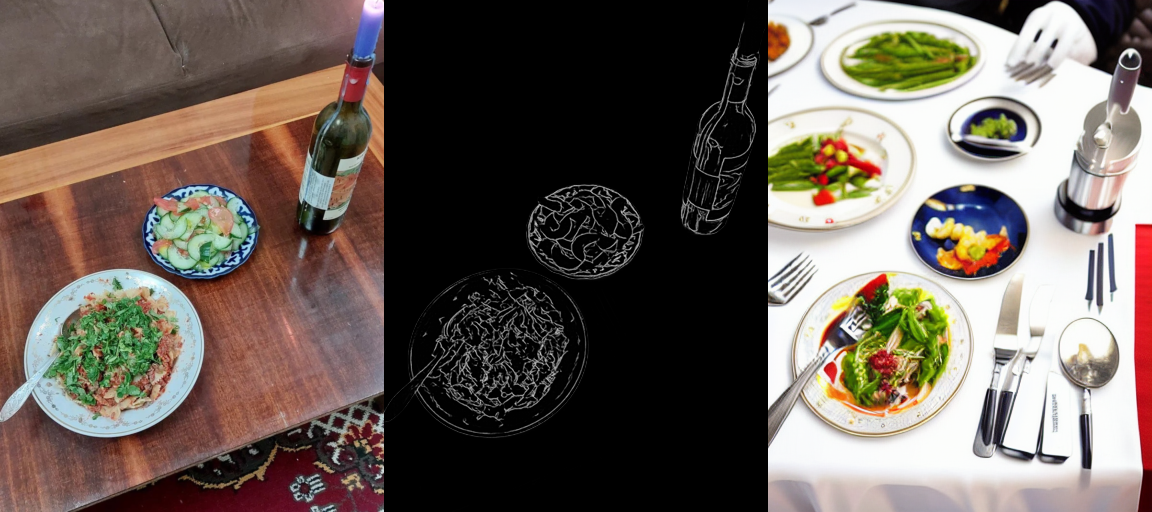

In [19]:
prompt = "many people at a served table, royal dinner, lots of cutlery next to plates, high-quality DSLR photo"
init_image = sd15_image_transform(load_image("./dataset/i.jpg"))
foreground_mask = foreground_segm_model(init_image, return_mask=True)
control_image = get_control_image(init_image)

# "Remove background" from the control image
control_image = Image.composite(
    control_image,
    Image.new('L', control_image.size, color='black'),
    foreground_mask
)

generated_image = text_to_image(prompt, control_image, controlnet_conditioning_scale=0.75)
display_row([init_image, control_image, generated_image])

This approach has downsides:
* control may still influence background, making it dull and less detailed,
* it's hard to use a different prompt for it.

So here's one better approach:

## Use diffusion inpainting for background

Diffusion inpainting is quite common and comes in many flavors.

In the most basic approach, the image to inpaint is noised to some extent (say 90%) in the latent space, then denoised back (which re-generates the entire image but preserving the general structure), and its part corresponding to the area to inpaint is pasted back into the original image.

On another extreme are conditioned diffusion models like ControlNets fine-tined specifically to the inpainting task.

I've read the code of StableDiffusionControlNetInpaintPipeline to learn that it does its own training-free algorithm:

1. The image is optionally cropped to the inpainting mask plus some margin (controlled with padding_mask_crop parameter; None = "don't apply this step") and resized to be convenient for the model (e.g. 512 x 512) in case the inpainting area is very small. Since we are dealing with background, padding_mask_crop=0 will often not crop anything. However, even in that case there is a subtle implementation difference: padding_mask_crop=None will re-generate the entire image (so the object may become slightly altered), while padding_mask_crop=0 will keep the object from the initial image as is and will only paste the inpainted parts. The former might be userful sometimes but I haven't seen much benefit from it, in my experience the latter works just right, and the distortion of the object could be significant with SD1.5.

1. The image to inpaint is mapped into the latent space and noise is added to some extent (strength parameter). 100% will ignore the existing content in the inpainting area, while <100% will try to follow the existing structure. When I used diffusers' inpainting for replacing faces I found 50% to be enough for changing facial identity. In this case however we need 100% since we are asked to re-generate background from scratch.

1. The inpainting mask is resized to the latent space spatial size (!). With our models, this means 8 times smaller (diffusion_pipeline.vae_scale_factor).

1. The original image is brought into the latent space. At each denoising step, it's added with noise according to our current noise level, and the parts that don't need to be inpainted (in our case, the object/person) from it are pasted into the current latent variable with the help of the "latent space mask" from the previous step.

Here is what it looks like, without ControlNet for now:

  0%|          | 0/30 [00:00<?, ?it/s]

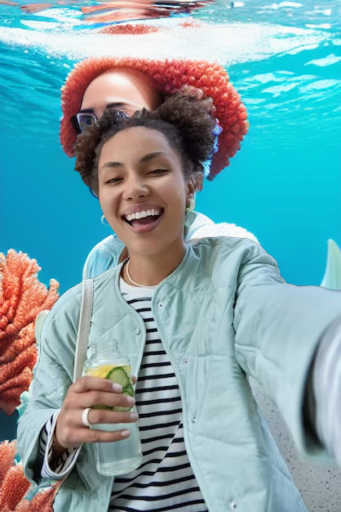

In [73]:
def inpaint_background(prompt, init_image, **extra_diffusion_kwargs):
    """
    Detect background in `init_image` and re-render it based on `prompt`.
    """
    foreground_mask = foreground_segm_model(init_image, return_mask=True)
    background_mask = ImageOps.invert(foreground_mask)

    if extra_diffusion_kwargs.get('controlnet_conditioning_scale', 0) != 0:
        control_image = get_control_image(init_image)
        # "Remove background" from the control image
        control_image = Image.composite(
            control_image,
            Image.new('L', control_image.size, color='black'),
            foreground_mask
        )
    else:
        control_image = init_image # doesn't matter anyway when scale is 0.0
    
    diffusion_kwargs = dict(
        prompt=prompt,
        negative_prompt="worst quality, low quality, blurry, ugly",
        image=init_image,
        mask_image=background_mask,
        control_image=control_image,
        controlnet_conditioning_scale=0.0,  # 0.0 = lineart control switched off
        num_inference_steps=30,
        padding_mask_crop=0,
        strength=1.0,
        generator=torch.Generator(device=diffusion_pipeline.device).manual_seed(123),
    )
    diffusion_kwargs.update(extra_diffusion_kwargs)
    return diffusion_pipeline(**diffusion_kwargs).images[0]

prompt = "a woman with corals and fish in the background"
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))

generated_image = inpaint_background(prompt, init_image)
display_row([generated_image])

Yes, inpainting is notorious for extra limbs. People usually fight this with prompt engineering and playing with control images.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

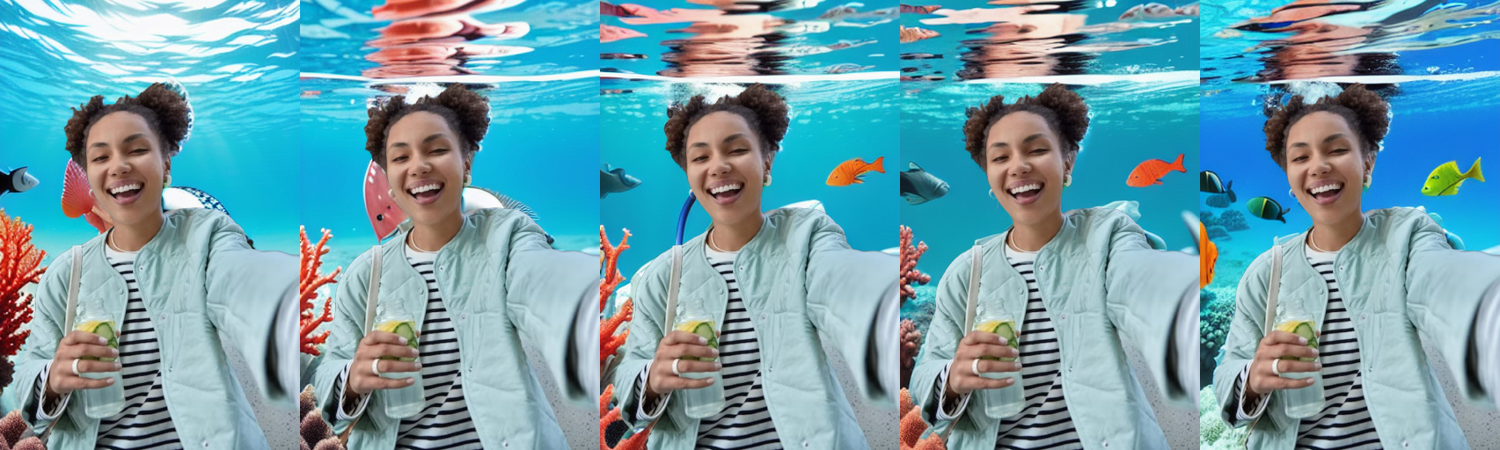

In [75]:
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))

prompt = "underwater, corals and fish in the background"
display_row([
    inpaint_background(prompt, init_image),
    inpaint_background(prompt, init_image, controlnet_conditioning_scale=0.25),
    inpaint_background(prompt, init_image, controlnet_conditioning_scale=0.5),
    inpaint_background(prompt, init_image, controlnet_conditioning_scale=0.75),
    inpaint_background(prompt, init_image, controlnet_conditioning_scale=1.0),
])

## Use diffusion inpainting for background in a generated image

If we combine the above methods, we can more or less solve the ultimate task:

In [94]:
def stylize(
    init_image,
    prompt,
    background_prompt=None,
    extra_fg_diffusion_kwargs=dict(),
    extra_bg_diffusion_kwargs=dict()
):
    """
    Stylize the foreground object in `init_image` based on `prompt` and draw
    a new background based on `background_prompt` (defaults to `prompt`).
    """
    if background_prompt is None:
        background_prompt = prompt

    foreground_mask = foreground_segm_model(init_image, return_mask=True)
    background_mask = ImageOps.invert(foreground_mask)

    control_image = get_control_image(init_image)
    # "Remove background" from the control image
    control_image = Image.composite(
        control_image,
        Image.new('L', control_image.size, color='black'),
        foreground_mask
    )

    # Step 1. Stylize the object
    diffusion_kwargs = dict(
        prompt=prompt,
        negative_prompt=["worst quality, low quality, blurry"][0],
        image=init_image,
        mask_image=Image.new('L', init_image.size, color='white'), # "inpaint everything"
        strength=1.0, # 1.0 = full noise, don't rely on existing content
        control_image=control_image,
        controlnet_conditioning_scale=0.85,
        guidance_scale=7.5,
        eta=0.0,
        num_inference_steps=30,
        padding_mask_crop=None,
        generator=torch.Generator(device="cuda").manual_seed(123),
    )
    diffusion_kwargs.update(extra_fg_diffusion_kwargs)
    foreground_stylized = diffusion_pipeline(**diffusion_kwargs).images[0]

    # This image will have a slightly different size due to VaeImageProcessor.process' behavior.
    # Resize back (restoring aspect ratio) because it's using resize_mode="default" here:
    # https://github.com/huggingface/diffusers/blob/5873377a660dac60a6bd86ef9b4fdfc385305977/src/diffusers/pipelines/controlnet/pipeline_controlnet_inpaint.py#L1313
    foreground_stylized = foreground_stylized.resize(init_image.size)

    # Step 2. Re-render (inpaint) the background
    diffusion_kwargs = dict(
        prompt=background_prompt,
        negative_prompt=["worst quality, low quality, blurry"][0],
        image=foreground_stylized,
        mask_image=background_mask,
        strength=1.0,
        control_image=control_image,
        controlnet_conditioning_scale=0.5,
        guidance_scale=7.5,
        eta=0.0,
        num_inference_steps=30,
        padding_mask_crop=0,
        generator=torch.Generator(device="cuda").manual_seed(123),
    )
    diffusion_kwargs.update(extra_bg_diffusion_kwargs)
    return diffusion_pipeline(**diffusion_kwargs).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

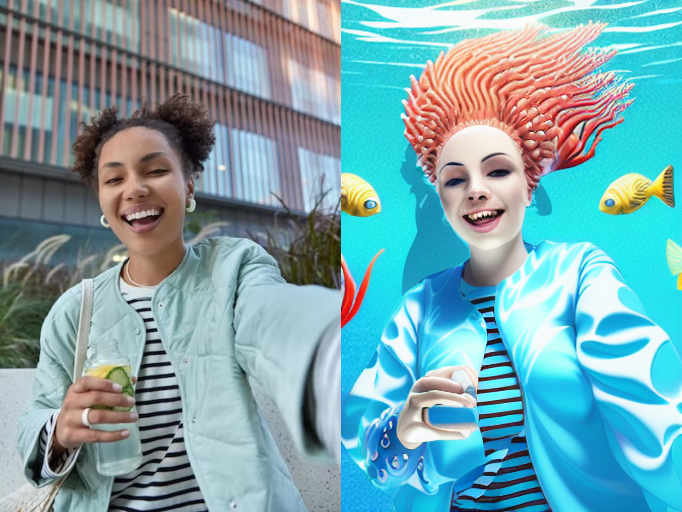

In [84]:
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
prompt = "mermaid underwater, blue clothes, corals and fishes background, realistic, high quality photo"
background_prompt = prompt
stylized_image = stylize(init_image, prompt, background_prompt)

display_row([init_image, stylized_image])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

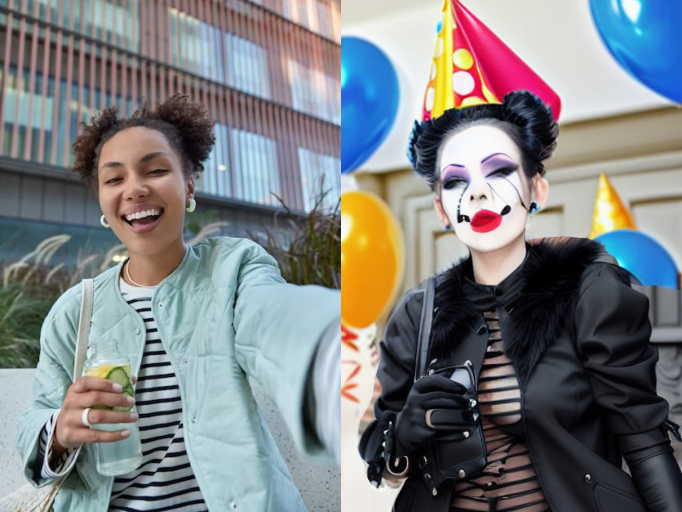

In [95]:
init_image = sd15_image_transform(load_image("./dataset/a.jpg"))
prompt = "a goth woman in a black outfit"
background_prompt = "at a kids birthday party"
stylized_image = stylize(init_image, prompt, background_prompt)

display_row([init_image, stylized_image])